# ニューラルネットワークの学習
参考図書：ゼロから作るDeep Learning  
このノートでは、参考書の第４章以降、すなわちニューラルネットワークの学習、誤差逆伝播などの実装技術を学ぶ。

## 損失関数
### 二乗和誤差
一般には次の二乗和誤差を用いることが多い。

$$ E = \frac{1}{2}\sum_{k}(y_k - t_k)^2 $$

$y_k$はニューラルネットワークの出力、$t_k$は教師データを表し、$k$はデータの次元数を表す

In [4]:
import numpy as np

In [5]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [6]:
# [2]を正解とする教師データ
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]

# 例１：[2]の確率が最も高い場合（0.6）
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))

# 例２：[7]の確率が最も高い場合（0.6）
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
print(mean_squared_error(np.array(y), np.array(t)))

0.09750000000000003
0.5975


### 交差エントロピー誤差
$$ E = - \sum_{k}t_k\log{y_k} $$

In [18]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t*np.log(y + delta)) # 微小量deltaを加えることでマイナスの無限大-infの出力を防ぐ

In [22]:
# 例えば
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0] # 正解ラベルは3番目
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

0.510825457099338

In [21]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t))

2.302584092994546

### ミニバッチ学習
今までは一つのデータに対して損失関数を考えていたが、実際には訓練データの数が100個あれば、その100個の損失関数の和を指標とする。  
すなわち
$$ E = - \frac{1}{N}\sum_{n}\sum_{k}t_{nk}\log{y_{nk}} $$

しかし、巨大なデータを扱うには、一気に損失関数の総和を求めるには時間がかかりすぎる。  
そこで、訓練データからある枚数だけを選び出し（これをミニバッチという）、それを全体の損失関数の近似とみなして、ミニバッチごとに学習を行う。

In [25]:
# MNISTデータからミニバッチを選び出すコード
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)

# 訓練データの中からランダムに10枚だけ抜き出す
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # train_size未満の自然数からランダムに10個の数字を選び出す
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]
print(x_batch.shape)
print(t_batch.shape)

# np.random.choiceの補足
np.random.choice(60000, 10)

(60000, 784)
(60000, 10)
(10, 784)
(10, 10)


array([56230, 19727,  4741, 40925, 51444, 11163,  3773, 11199, 53359,
       31692])

In [27]:
# 交差エントロピー誤差をミニバッチ学習に対応させる
def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y + 1e-7)) / batch_size

## 勾配法

In [28]:
def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列を生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h)の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h)の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 値をもとに戻す
        
    return grad

In [29]:
# 勾配計算の実験
def function_2(x):
    return x[0]**2 + x[1]**2
    # または return np.sum(x**2)
    
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [30]:
# 勾配降下法の実装
def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
        
    return x

引数のfは最適化したい関数、init_xは初期値、lrはlearning rateを意味する学習率、step_numは勾配法による繰り返しの数  
試しに次の問題に適用してみる。

$ f(x_0, x_1) = {x_0}^2 + {x_1}^2 $の最小値を勾配法で求めよ。

In [31]:
init_x = np.array([-3.0, 4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

結果はほぼ0だから、正しい結果。  
学習率や繰り返しの数は人間が適切に設定しなければならない。

In [34]:
# 簡単なニューラルネットワークを例に勾配を求める実装
import numpy as np
import sys, os
sys.path.append(os.pardir)
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

class simpleNet:
    # 形状2×3の重みパラメータ
    def __init__(self):
        self.W = np.random.randn(2, 3) # ガウス分布で初期化
        
    # 予測のためのメソッド
    def predict(self, x):
        return np.dot(x, self.W)
    
    # 損失関数の値を求めるメソッド
    # 引数のxには入力データ、tには正解ラベルが入力される
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [35]:
# 実験
net = simpleNet()
print(net.W) # 重みパラメータ

x = np.array([0.6, 0.9])
p = net.predict(x)
print(p)
print(np.argmax(p)) # 最大値のインデックス

t = np.array([0, 0, 1]) # 正解ラベル
net.loss(x, t)

[[-0.95359659  0.11174246  0.32618324]
 [ 0.05947028  0.40103842  0.70174092]]
[-0.5186347   0.42798005  0.82727677]
2


0.6580864787950823

In [37]:
# 勾配を求める
f = lambda w: net.loss(x, t)
dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.08087715  0.20841808 -0.28929523]
 [ 0.12131572  0.31262712 -0.43394285]]


## 学習アルゴリズムの実装

学習手順のまとめ
* 前提
    * 適応可能な重みとバイアスがあり、これらを訓練データに適応するように調整することを学習と呼ぶ
* ステップ1（ミニバッチ）
    * 訓練データの中からランダムに一部のデータを選び出す
    * これをミニバッチと呼ぶ
    * ミニバッチの損失関数の値を減らすことをまずは目的に
* ステップ2（勾配の算出）
    * ミニバッチの損失関数を減らすために、各重みのパラメータの勾配を求める
    * 勾配＝損失関数の値をもっと減らす方向（ベクトル）
* ステップ3（パラメータの更新）
    * 重みパラメータを勾配方向に微小量（＝学習率 learning rate）だけ更新する
* ステップ4（繰り返し）
    * ステップ1~3を繰り返す（＝反復回数iterationを指定）
    
この手法は、確率的勾配降下法（＝stochastic gradient descent or **SGD**)と呼ばれる。

### 2層ニューラルネットワークのクラスの実装

In [38]:
import sys, os
sys.path.append(os.pardir)
from common.functions import *
from common.gradient import numerical_gradient

class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 重みの初期化
        self.params = {} # ニューラルネットワークのパラメータを保持するディクショナリ変数（インスタンス変数）
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size) # 1層目の重み
        self.params['b1'] = np.zeros(hidden_size) # 1層目のバイアス
        self.params['W2'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
    
    # 損失関数の値を求める
    # x:入力データ、t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    # 認識精度を求める関数
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    # 重みパラメータに対する勾配を求める関数
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads

## 誤差逆伝播法

In [7]:
# 乗算レイヤの実装
class MulLayer:
    def __init__(self):
        self.x = None
        self.y = None
        
    def forward(self, x, y):
        self.x = x
        self.y = y
        out = x * y
        
        return out
    
    def backward(self, dout):
        dx = dout * self.y # ここで順伝播時の入力値を再利用する
        dy = dout * self.x
        
        return dx, dy

In [8]:
# りんごの買い物の例
apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(dapple, dapple_num, dtax)

220.00000000000003
2.2 110.00000000000001 200


In [9]:
# 加算レイヤの実装
class AddLayer:
    def __init__(self):
        pass # 初期化が必要ないので、何も行わない
    
    def forward(self, x, y):
        out = x + y
        return out
    
    def backward(self, dout):
        dx = dout * 1
        dy = dout * 1
        return dx, dy

In [12]:
# リンゴ2個とミカン3個の買い物の実装
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


In [13]:
# Sigmoidレイヤの実装
class Sigmoid:
    def __init__(self):
        self.out = None
        
    def forward(self, x):
        out = 1 / (1 + np.exp(-x))
        self.out = out
        
        return out
    
    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out
        
        return dx

In [14]:
# Affineレイヤの実装
class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None
        
    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b
        
        return out
    
    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        return dx

In [15]:
# Softmax-with-Lossレイヤの実装
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None # softmaxの出力
        self.t = None # 教師データ

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 教師データがone-hot-vectorの場合
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size

        return dx

In [45]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict


class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

0.11093333333333333 0.1085
0.9042333333333333 0.91
0.92125 0.923
0.9357 0.9332
0.9462333333333334 0.943
0.9514166666666667 0.9492
0.955 0.9524
0.9589333333333333 0.9565
0.9630666666666666 0.9596
0.96555 0.9593
0.9677166666666667 0.9626
0.9709666666666666 0.9641
0.9720333333333333 0.9656
0.9736833333333333 0.9655
0.9759 0.9659
0.9759666666666666 0.9691
0.9763 0.9661


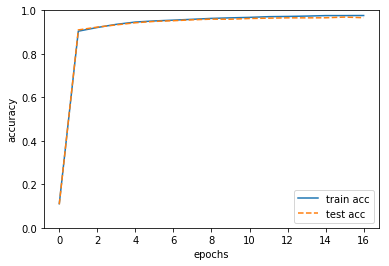

In [47]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)

import numpy as np
from dataset.mnist import load_mnist
import matplotlib.pyplot as plt

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 勾配
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)

    # 更新
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print(train_acc, test_acc)


markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()